In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [2]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2017-03-19 17:33:31,470 Loading LFW people faces from C:\Users\Rodrigo\scikit_learn_data\lfw_home


In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [4]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [5]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 966 faces
done in 0.583s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.032s


In [8]:
pca.explained_variance_ratio_

array([ 0.19346361,  0.15116848,  0.07083635,  0.05952005,  0.05157536,
        0.02887197,  0.02514493,  0.02176448,  0.02019352,  0.01902112,
        0.01682188,  0.0158062 ,  0.01223357,  0.01087943,  0.0106444 ,
        0.00979658,  0.0089241 ,  0.0085485 ,  0.00835738,  0.00722657,
        0.00696581,  0.00653869,  0.0063956 ,  0.00561312,  0.00531102,
        0.00520163,  0.0050747 ,  0.00484213,  0.00443595,  0.00417821,
        0.00393694,  0.00381731,  0.00356076,  0.00351191,  0.00334556,
        0.00329938,  0.00314638,  0.00296215,  0.00290127,  0.00284711,
        0.00279987,  0.00267544,  0.00259904,  0.0025838 ,  0.00240922,
        0.00238994,  0.00235418,  0.00222583,  0.00217506,  0.00216561,
        0.00209062,  0.00205427,  0.00200427,  0.00197382,  0.00193834,
        0.00188755,  0.00180168,  0.0017889 ,  0.00174819,  0.00173049,
        0.00165648,  0.00162947,  0.00157419,  0.0015342 ,  0.00149969,
        0.00147251,  0.00143909,  0.00141875,  0.00139689,  0.00

In [9]:
###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 21.922s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Predicting the people names on the testing set
done in 0.067s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.76      0.88      0.82        60
  Donald Rumsfeld       0.73      0.70      0.72        27
    George W Bush       0.92      0.87      0.89       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.83      0.83      0.83       322

[[  8   0   3   2   0   0   0]
 [  2  53   1   3   0   1   0]
 [  4   1  19   2   0   0   1]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  20   1   1]
 [  0   2   0   1   2   9   1]
 [  1   1   1   2   1   0  30]]


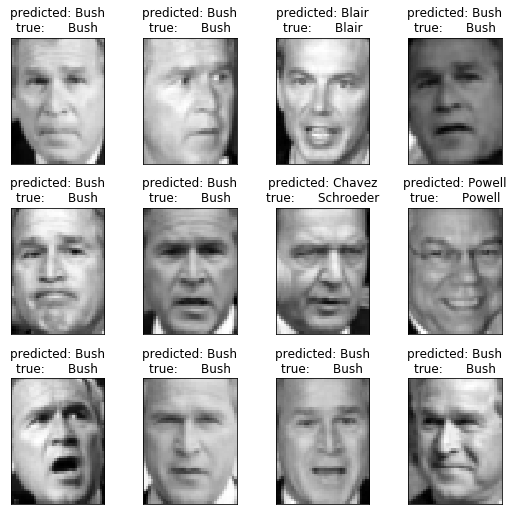

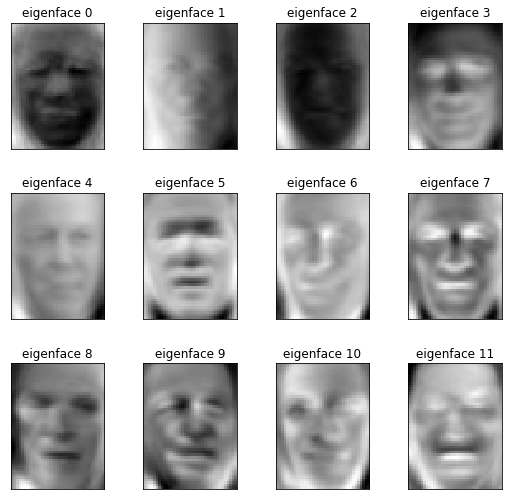

In [10]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()